In [35]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
# from sklearn.manifold import TSNE
# import hdbscan as hdb
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from PIL import Image
from itertools import cycle
from random import randint
import re, math
import seaborn as sns; sns.set_style("white")
import umap as umap
import datetime
import gc
from pathlib import Path

# import plotnine as gg
# from cytominer_eval import evaluate
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
pio.renderers

os.getcwd()

'/scratch2-shared/david/colopaint3D/notebooks'

In [36]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./output/3_PCAUMAP'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './output/2_FIM'
trainarg = 'all'

In [37]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    
    return ax.add_patch(ellipse)


In [38]:
# AllFrameNdarray = AllFrames.to_numpy(copy=True)
# df2npy = frameFeatures.drop(columns=['DRUG_NAME'])
# frameNpy = df2npy.to_numpy()
read_data = pd.read_parquet('output/2_FIM/spheroidSingleCell.parquet')
# arglist = ['BzCl 100', 'Stauro 2', 'FCCP 10', 'DMSO']
cbar = pd.DataFrame()
# training_data = training_data[training_data['drug'].isin(arglist)]
read_data.reset_index(inplace=True, drop = True)
# training_data.drop(columns=['drug_name', 'ImageNumber_nuclei', 'Metadata_Site_nuclei'], inplace=True)

In [39]:
training_data = read_data.copy()

#
# training_data = training_data.loc[:,~training_data.columns.str.contains('AreaShape_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Correlation_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Granularity_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Intensity_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('RadialDistribution_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Neighbors_', case=False)]
# loc_dataX = training_data.loc[:,training_data.columns.str.contains('_X', case=True)]
# loc_dataX = loc_dataX.copy()
# loc_dataY = training_data.loc[:,training_data.columns.str.contains('_Y', case=True)]
# loc_dataY = loc_dataY.copy()
loc_data = training_data[['Nuclei_Location_Center_X','Nuclei_Location_Center_Y']]
# loc_data = loc_data - loc_data.mean()
# loc_data['loc_R'] = loc_data.apply(lambda x: (x['Nuclei_Location_Center_X']**2 + x['Nuclei_Location_Center_Y']**2)**0.5, axis = 1)
training_data = training_data.loc[:,~training_data.columns.str.contains('Location', case=True)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('ObjectNumber_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('ImageNumber_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Parent', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Children', case=True)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Neighbors_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_ObjectNumber', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Object_Number', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Y', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_X', case=True)]
# zplane = training_data['Metadata_Plane'].pop()
df_norm = training_data.select_dtypes(include=np.number)
df_norm = df_norm.loc[:,~df_norm.columns.str.contains('Metadata_', case=True)]
df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min()) 
df_norm = df_norm.fillna(0)
training_data[df_norm.columns] = df_norm

#Correlation contains some kind of well information

# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]
training_data_out = training_data
# training_data['Metadata_Plane'] = zplane

toNpy = training_data.loc[:,~training_data.columns.str.contains('Metadata_')]
toNpy.reset_index(inplace=True, drop=True)

# training_data.dropna(axis=1, inplace=True)
training_data_out.to_csv('training_data.csv', sep=';')

In [40]:
# toframe = training_data.drop(columns=['drug_name'])
#Always gonna be 1

dataNpy = toNpy.to_numpy()
colnames = toNpy.columns
# del read_data
# del toNpy
# del training_data_out
# gc.collect()


In [41]:
loc_data

,Nuclei_Location_Center_X,Nuclei_Location_Center_Y
0,836.941467,356.980194
1,819.587402,359.506653
2,814.984802,358.368805
3,804.334839,358.531830
4,800.463379,355.611725
...,...,...
46549,494.177856,786.470947
46550,681.956238,520.510254
46551,391.219513,788.148804
46552,626.782959,832.503113


In [42]:
np.isnan(dataNpy).any()

False

In [26]:
# perplex = 20

variant = 'PCA_All'


pca_model = PCA(n_components=  2)
pca_model = pca_model.fit(dataNpy)
pcaOut = pca_model.transform(dataNpy)

umap_model = umap.UMAP(n_neighbors=15
                       , min_dist=0.5
                       )
umapOut = umap_model.fit_transform(dataNpy)

# labels = hdb.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=70,
# ).fit_predict(umapOut)
training_data = training_data.copy()
training_data['pc1'] = pcaOut[:,0]
training_data['pc2'] = pcaOut[:,1]

training_data['umap1'] = umapOut[:,0]
training_data['umap2'] = umapOut[:,1]
# training_data['cluster'] = labels
# training_data['loc_X'] = loc_data['Nuclei_Location_Center_X']
# training_data['loc_Y'] = loc_data['Nuclei_Location_Center_Y']
# training_data['loc_R'] = loc_data['loc_R']

In [27]:
metaEx = pd.read_csv('/home/jovyan/scratch2-shared/david/colopaint3D/notebooks/settings/pilot12-v2-Adjusted_5-metadata.csv', sep=',')

In [28]:

training_data['cmpdname'] = training_data['Metadata_Well'].apply(lambda x: metaEx.loc[metaEx['well_id'] == x, 'cmpdname'].values[0])

In [32]:
metaEx['cmpdname'].unique()

array(['etop', 'berb', 'tetr', 'stau', 'dmso', 'noco ', 'IWR-1', 'fenb',
       'CA-074', 'sorb', 'flup'], dtype=object)

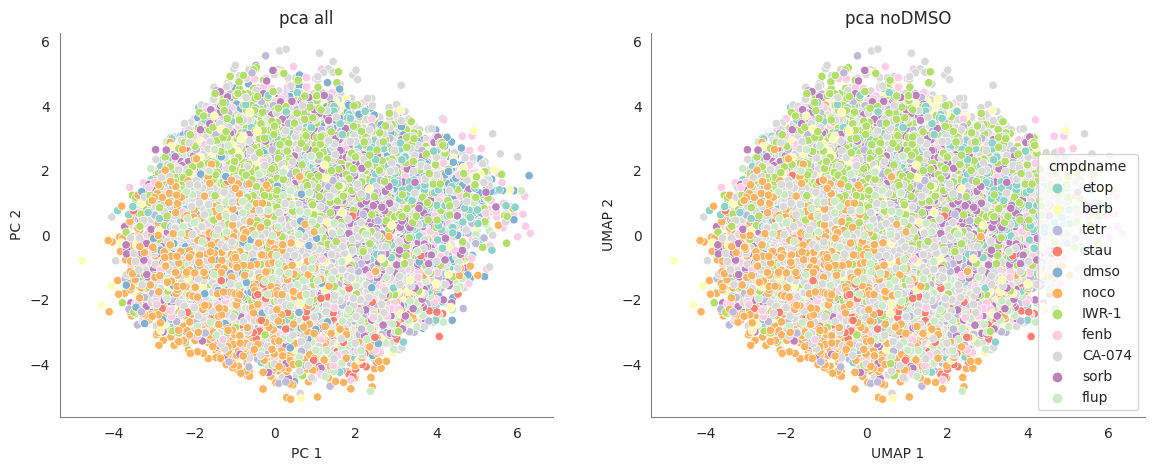

In [34]:
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = training_data['cmpdname']
# hue = training_data['cluster']
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                    data=training_data).set(title=f'pca all'
            )


noDMSO = training_data[~(training_data['cmpdname'] == 'dmso')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                    data=noDMSO).set(title=f'pca noDMSO'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/pca.png')
plt.show()
plt.close()

In [89]:
# xlimPCA = [training_data['pc1'].min() - 0.2*abs(training_data['pc1'].min()), training_data['pc1'].max() + 0.2*abs(training_data['pc1'].max())]
# ylimPCA = [training_data['pc2'].min() - 0.2*abs(training_data['pc2'].min()), training_data['pc2'].max() + 0.2*abs(training_data['pc2'].max())]
# xlimUMAP = [training_data['umap1'].min() - 2, training_data['umap1'].max() + 0.2*abs(training_data['umap1'].max())]
# ylimUMAP = [training_data['umap2'].min() - 2, training_data['umap2'].max() + 0.2*abs(training_data['umap2'].max())]